In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing import timeseries_dataset_from_array
import tensorflow_datasets as tfds
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle
import math 
import time 
import datetime
import glob

from Helpers import save_to_disk, load_from_disk 
from DatasetHelpers import create_seq_to_datapoint_ds, seq_to_dp_ds_from_df_list, create_pretrain_ds, pretrain_ds_from_df_list, train_validation_split_ds 


Using TensorFlow backend.


In [2]:
final_data_path = "./final_data/"
all_data = load_from_disk(final_data_path + "full_filtered_data.pickle")

model_save_path = "./trained_models/"
model_load_path = "./trained_models/encoder_only_pretrain_finetune2_2022_06_12_09_20_32.h5"


main_train_epochs = 90
first_finetune_epochs = 40 
second_finetune_epochs = 30 

# reduce training data to minimum for debug purposes 
debug_reduce_data = False

# Extract training data

In [3]:
# Get Westbrueck segments
# Train only on Westbrueck segments

westbrueck_cnt = 0
autobahn_cnt = 0
countryroad_cnt = 0
mountainroad_cnt = 0 

westbrueck_segments = [] # list of dfs 

for participant in all_data:
    for area in all_data[participant]:
        for segment in all_data[participant][area]:
            
            if area == "Autobahn":
                autobahn_cnt += 1
            if area == "CountryRoad":
                countryroad_cnt += 1
            if area == "MountainRoad":
                mountainroad_cnt += 1
            if area == "Westbrueck":
                westbrueck_cnt += 1
                westbrueck_segments.append(all_data[participant][area][segment])
                

print("Available Segments in Areas:")
print("Autobahn:",autobahn_cnt,"\tWestbrueck:",westbrueck_cnt,"\tCountryRoad:",countryroad_cnt,"\tMountainRoad:",mountainroad_cnt)

Available Segments in Areas:
Autobahn: 364 	Westbrueck: 523 	CountryRoad: 185 	MountainRoad: 372


In [4]:
# Keep only certain features in df 
# Extract feature bounds 
# Keep only certain segments based on max(abs(feature value)) 
# Extract test segment (for later testing)

# (All world coordinates relate not to Unity world space anymore, but to car space)

test_segment_idx = 17
test_segment_data = None

westbrueck_condensed_segments = []
large_values_idx_excluded = []

feature_bound_threshold = 4 # exclude feature with abs values greater than 4, Results for > 100 are almost the same as for > 4

keep_features = ["HmdPosition.x","HmdPosition.y","HmdPosition.z","NoseVector.x","NoseVector.y","NoseVector.z","EyePosWorldCombined.x","EyePosWorldCombined.y","EyePosWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]
feature_bounds = {}
current_segment_bounds = {}
for feature in keep_features:
    feature_bounds[feature] = 0
    current_segment_bounds[feature] = 0


for idx, segment in enumerate(westbrueck_segments):
    segment = segment[keep_features]
    
    keep_segment = True
    
    for feature in keep_features:
        current_segment_bounds[feature] = 0

    # collect min/max values per feature 
    for feature in keep_features:
        feature_bound = np.maximum(np.abs(segment[feature].min()),np.abs(segment[feature].max()))
        
        # store current bound 
        if feature_bound > current_segment_bounds[feature]:
            current_segment_bounds[feature] = feature_bound
        
        # Exclude segments with big bounds
        if feature_bound > feature_bound_threshold:
            if idx not in large_values_idx_excluded:
                large_values_idx_excluded.append(idx)
            keep_segment = False
        
    if idx == test_segment_idx:
        print("Extracted test segment data with shape",segment.shape)
        test_segment_data = segment
        
        '''
        # excluded for training June 2022
        # update final feature bounds from current bounds
        for feature in keep_features:
            if current_segment_bounds[feature] > feature_bounds[feature]:
                feature_bounds[feature] = current_segment_bounds[feature]
        '''
        
        continue

    if keep_segment:
        westbrueck_condensed_segments.append(segment)
        
        # update final feature bounds from current bounds
        for feature in keep_features:
            if current_segment_bounds[feature] > feature_bounds[feature]:
                feature_bounds[feature] = current_segment_bounds[feature]
        

print("Excluded number of Westbrueck Segments:", len(large_values_idx_excluded))
print("Kept number of Westbrueck Segments:", len(westbrueck_condensed_segments))

Extracted test segment data with shape (1767, 12)
Excluded number of Westbrueck Segments: 99
Kept number of Westbrueck Segments: 423


In [5]:
# Check for nans 
for df in westbrueck_condensed_segments:
    if df.isnull().values.any():
        print("Found NaNs")
        break

In [6]:
feature_bounds

{'HmdPosition.x': 3.6055908203125,
 'HmdPosition.y': 1.6842193603515625,
 'HmdPosition.z': 2.609619140625,
 'NoseVector.x': 0.9996606007100145,
 'NoseVector.y': 0.8368004900723452,
 'NoseVector.z': 0.9999999999533711,
 'EyePosWorldCombined.x': 3.7421112060546875,
 'EyePosWorldCombined.y': 1.69110107421875,
 'EyePosWorldCombined.z': 2.614990234375,
 'EyeDirWorldCombined.x': 0.999987858555089,
 'EyeDirWorldCombined.y': 0.9978489911694244,
 'EyeDirWorldCombined.z': 0.9999999999533711}

In [7]:
# Scale data  

if True:
    print("Using scaled data")
    for df in westbrueck_condensed_segments:
        for feature in keep_features:
            df.loc[:,feature] = df[feature] / np.ceil(feature_bounds[feature])

    for feature in keep_features:
        test_segment_data.loc[:,feature] = test_segment_data[feature] / np.ceil(feature_bounds[feature])
else:
    print("Using data without scaling")


Using scaled data


/Users/stefan/opt/anaconda3/envs/Head2Eye/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [8]:
test_segment_data.abs().max()

HmdPosition.x            0.145309
HmdPosition.y            0.550781
HmdPosition.z            0.161560
NoseVector.x             0.157107
NoseVector.y             0.204073
NoseVector.z             0.990894
EyePosWorldCombined.x    0.144699
EyePosWorldCombined.y    0.552841
EyePosWorldCombined.z    0.153198
EyeDirWorldCombined.x    0.610110
EyeDirWorldCombined.y    0.353685
EyeDirWorldCombined.z    0.999922
dtype: float64

In [9]:
if debug_reduce_data:
    westbrueck_condensed_segments = westbrueck_condensed_segments[:1]

# Generate Datasets

In [10]:
input_feature_dim = 6
seq_slice_len = 200
batch_size = 64
do_size_log = False
shuffle = True
shuffle_buffer = 2048
val_frac = 0.1

In [11]:
# Feature list, all other columns are targets 
feature_list = ["HmdPosition.x", "HmdPosition.y", "HmdPosition.z", "NoseVector.x", "NoseVector.y", "NoseVector.z"]

# Pretrain 
westbrueck_pretrain_ds = pretrain_ds_from_df_list(westbrueck_condensed_segments, feature_list, seq_slice_len, mask_mode = "pretrain", batch_size = batch_size, do_size_log = False)
westbrueck_pretrain_train, westbrueck_pretrain_validation = train_validation_split_ds(westbrueck_pretrain_ds, val_frac, shuffle, shuffle_buffer)

# Actual data
westbrueck_dataset = seq_to_dp_ds_from_df_list(westbrueck_condensed_segments,input_feature_dim, seq_slice_len, True, batch_size, do_size_log = False)
westbrueck_train, westbrueck_validation = train_validation_split_ds(westbrueck_dataset, val_frac, shuffle, shuffle_buffer)


Creating dataset from Dataframe List.
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 
Shuffling dataset
Full Dataset size: 12256
Train Dataset size: 11030
Validate Dataset size: 1226
Creating dataset from Dataframe List.
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 
Shuffling dataset
Full Dataset size: 12256
Train Dataset size: 11030
Validate Dataset size: 1226


# Model

In [12]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=dense_dim
        )
        self.dense_proj = keras.Sequential(                        
            [layers.Dense(dense_dim, activation="tanh"), layers.Dense(embed_dim),]  # activation relu 
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads
        })
        return config
      

    def call(self, inputs, mask=None):
        
        
        if mask is not None:
            #padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32") # dtype int32 
            padding_mask = mask
        

        (attention_output, attention_scores) = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask, return_attention_scores = True
        )

        
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
             
        return self.layernorm_2(proj_input + proj_output)

    
    
class PositionalEmbedding(layers.Layer):
    
    
    def __init__(self, sequence_length, feature_dim, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        
        # Save init values
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.embed_dim = embed_dim 
        
        # Init dense projection, only last dim is affected by Dense layer
        self.dense_proj = keras.Sequential([layers.Dense((self.feature_dim * self.embed_dim), activation="tanh"),\
                                           keras.layers.Reshape((sequence_length, self.feature_dim * self.embed_dim ))])
        

        # Calculate Positional Embedding 
        self.pos_embed = self._calculate_positional_embedding(self.sequence_length, self.feature_dim * self.embed_dim) 


    def _calculate_positional_embedding(self, position, d_model):

        def get_angles(pos, i, d_model):
            angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
            return pos * angle_rates

        angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                                  np.arange(d_model)[np.newaxis, :],
                                  d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)


    def call(self, inputs):

        # Add embedding dimensions  
        inputs = self.dense_proj(inputs)

        # Positional embedding 
        pos_embedding = self.pos_embed
        
        return inputs + pos_embedding 
        
        
        
    def compute_mask(self, inputs, mask=None):

        return tf.ones((tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[1])) 

    
    # allow saving 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'feature_dim': self.feature_dim,
            'embed_dim': self.embed_dim
        })
        return config
    
  


In [13]:
def masked_mse(y_true, y_pred, mask):
    '''
    Apply mask to true and to predicted values, i.e. calculate MSE only for values visible through the mask.
    mask value of 1 represent values taken into account for MSE. 
    '''
    
    y_true_masked = tf.math.multiply(y_true, mask)
    y_pred_masked = tf.math.multiply(y_pred, mask)
    
    mse = tf.keras.losses.mean_squared_error(y_true = y_true_masked, y_pred = y_pred_masked)
    
    return mse

In [14]:
def build_transformer_encoder_masked_model(seq_slice_len, feature_dim, embed_dim, latent_dim, num_heads, num_encoder_units):
    '''
    Transformer Encoder With Input Masking and masked MSE  
    seq_slice_len:      Length of the sequence (slice, taken from the full sequence)
    feature_dim:        Dimension of input data (i.e. how many times seq_len is included)
    embed_dim:          Dimensions that should be added on top (multiplying size)
    latent_dim:         Internals of transformer
    num_heads:          Internals of transformer 
    num_encoder_units:  Number of encoder units to be stacked  
    '''
    
    # Mask input 
    mask_inputs = keras.Input(shape=(seq_slice_len, feature_dim), dtype="float32", name="mask_inputs") 

    
    # Input of shape (sequence_length, feature_dim)
    # Pointwise multiplied with mask to blank out some input 
    # Projected (with additional positional embedding) to shape (sequence_length, feature_dim * embed_dim)
    encoder_inputs = keras.Input(shape=(seq_slice_len, feature_dim), dtype="float32", name="encoder_inputs") 
    
  
    masked_encoder_inputs = keras.layers.Multiply()([encoder_inputs, mask_inputs])
    x_encoder = PositionalEmbedding(seq_slice_len, feature_dim = feature_dim, embed_dim = embed_dim)(masked_encoder_inputs)

    # Transformer Encoder
    encoder_outputs = TransformerEncoder(dense_dim = latent_dim, embed_dim = feature_dim * embed_dim, num_heads = num_heads)(x_encoder)

    # Stack more encoders if specified
    for idx in range(num_encoder_units - 1):
        encoder_outputs = TransformerEncoder(dense_dim = latent_dim, embed_dim = feature_dim * embed_dim, num_heads = num_heads)(encoder_outputs)

    # Reshape output 
    
    #dense_outputs = layers.Dense(embed_dim*feature_dim)(encoder_outputs)
    dense_outputs = layers.Dense(feature_dim)(encoder_outputs)
    dense_outputs = layers.Reshape((seq_slice_len,feature_dim))(dense_outputs)

    # Generate Model
    encoder_only_pretrain = keras.Model(inputs=[encoder_inputs,mask_inputs], outputs=dense_outputs)
    
    # Add custom masked mse loss 
    # Invert the mask, as for the loss, those values that were 0ed in the input should be considered  
    encoder_only_pretrain.add_loss(masked_mse(encoder_inputs, dense_outputs, 1 - mask_inputs))
    
    return encoder_only_pretrain
    

In [15]:
# seq_len from above
feature_dim = 6 #2 
embed_dim = 2 
latent_dim = 2048
num_heads = 3 #8
num_encoder_units = 1 #2
target_is_seq = False  

encoder_only_model_pretrain = build_transformer_encoder_masked_model(seq_slice_len, feature_dim, embed_dim, latent_dim, num_heads, num_encoder_units)

# Pretrain 

In [15]:
use_model_name = "encoder_only_pretrain"
use_real_data = True
use_model = encoder_only_model_pretrain
use_model.summary()


tf.keras.backend.clear_session()

# use loss specified within the model 
use_model.compile(
    "adam", metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'],
    run_eagerly = False 
)


use_model.fit(westbrueck_pretrain_train, epochs=main_train_epochs, validation_data=westbrueck_pretrain_validation) 


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
mask_inputs (InputLayer)        [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
multiply (Multiply)             (None, 200, 6)       0           encoder_inputs[0][0]             
                                                                 mask_inputs[0][0]                
__________________________________________________________________________________________________
positional_embedding (Positiona (None, 200, 12)      84          multiply[0][0]               

# Save

In [18]:
def get_date_time():
    return str(datetime.datetime.now()).replace("-","_").replace(" ","_").replace(":","_").split(".")[0]

In [19]:
full_save_path = model_save_path + use_model_name + "_" + get_date_time() + ".h5"
use_model.save(full_save_path, save_format = "h5" )


In [20]:
glob.glob(model_save_path + use_model_name + "*.*")

['./trained_models/encoder_only_pretrain_finetune2_2022_04_18_18_32_19.h5',
 './trained_models/encoder_only_pretrain_finetune1_2022_04_18_18_30_37.h5',
 './trained_models/encoder_only_pretrain_2022_05_26_15_45_40.h5',
 './trained_models/encoder_only_pretrain_2022_04_18_17_29_03.h5',
 './trained_models/encoder_only_pretrain_finetune2_2022_04_18_18_21_06.h5',
 './trained_models/encoder_only_pretrain_finetune1_2022_04_18_17_31_06.h5',
 './trained_models/encoder_only_pretrain_finetune2_2022_04_18_17_34_59.h5',
 './trained_models/encoder_only_pretrain_finetune2_2022_04_18_18_20_56.h5']

# Fine-Tuning

In [22]:
use_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
mask_inputs (InputLayer)        [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
multiply (Multiply)             (None, 200, 6)       0           encoder_inputs[0][0]             
                                                                 mask_inputs[0][0]                
__________________________________________________________________________________________________
positional_embedding (Positiona (None, 200, 12)      84          multiply[0][0]               

In [23]:
# cut off dense head, make main layers untrainable 

layers = use_model.layers[:-10]

for layer in layers:
    layer.trainable = False

last_layer_out = layers[-1].output
first_dense = tf.keras.layers.Dense(feature_dim * embed_dim, activation="tanh", trainable = True, name = "ft_dense_1")(last_layer_out)
flatten = tf.keras.layers.Flatten(name = "ft_flatten")(first_dense)
second_dense = tf.keras.layers.Dense(feature_dim, activation="tanh", trainable = True, name = "ft_dense_2")(flatten)
reshape = tf.keras.layers.Reshape((1, feature_dim), name = "ft_reshape")(second_dense)


modified_pretrained_encoder = keras.Model(inputs=use_model.input, outputs=reshape)


In [24]:
# For finetuning use standard mse 
modified_pretrained_encoder.compile(
    "adam", loss="mse", metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'], # rmsprop # sparse_categorical_crossentropy # mse
    run_eagerly = False
)
modified_pretrained_encoder.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
mask_inputs (InputLayer)        [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
multiply (Multiply)             (None, 200, 6)       0           encoder_inputs[0][0]             
                                                                 mask_inputs[0][0]                
__________________________________________________________________________________________________
positional_embedding (Positiona (None, 200, 12)      84          multiply[0][0]               

In [25]:
# First Finetune 

modified_pretrained_encoder.fit(westbrueck_train, epochs=first_finetune_epochs, validation_data=westbrueck_validation)  

full_save_path = model_save_path + use_model_name + "_finetune1_" + get_date_time() + ".h5"
modified_pretrained_encoder.save(full_save_path, save_format = "h5" )


27/27 [==============================] - 49s 2s/step - loss: 0.2638 - mean_squared_error: 0.2638 - mean_absolute_error: 0.4030 - mean_absolute_percentage_error: 2285.5675 - cosine_proximity: 0.6212 - val_loss: 0.2812 - val_mean_squared_error: 0.2812 - val_mean_absolute_error: 0.3475 - val_mean_absolute_percentage_error: 346.7598 - val_cosine_proximity: 0.6220


In [26]:
# Second finetune 

# Make all layers trainable 
for layer in modified_pretrained_encoder.layers:
    layer.trainable = True
    
more_modified_pretrained_encoder = keras.Model(inputs=modified_pretrained_encoder.input, outputs=modified_pretrained_encoder.output)
    
# Fine tune with smaller learning rate 
more_modified_pretrained_encoder.compile(
    optimizer=keras.optimizers.Adam(1e-5), loss="mse", metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'], # rmsprop # sparse_categorical_crossentropy # mse
    run_eagerly = False
)
more_modified_pretrained_encoder.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
mask_inputs (InputLayer)        [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
multiply (Multiply)             (None, 200, 6)       0           encoder_inputs[0][0]             
                                                                 mask_inputs[0][0]                
__________________________________________________________________________________________________
positional_embedding (Positiona (None, 200, 12)      84          multiply[0][0]             

In [27]:
more_modified_pretrained_encoder.fit(westbrueck_train, epochs=second_finetune_epochs, validation_data=westbrueck_validation)   


27/27 [==============================] - 116s 4s/step - loss: 0.2225 - mean_squared_error: 0.2225 - mean_absolute_error: 0.2988 - mean_absolute_percentage_error: 839.6845 - cosine_proximity: 0.7017 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - val_mean_absolute_error: 0.1884 - val_mean_absolute_percentage_error: 247.4498 - val_cosine_proximity: 0.8828


In [28]:
full_save_path = model_save_path + use_model_name + "_finetune2_" + get_date_time() + ".h5"
more_modified_pretrained_encoder.save(full_save_path, save_format = "h5")


In [29]:
for i, w in enumerate(modified_pretrained_encoder.weights): print(i, w.name)

0 dense/kernel:0
1 dense/bias:0
2 transformer_encoder/multi_head_attention/query/kernel:0
3 transformer_encoder/multi_head_attention/query/bias:0
4 transformer_encoder/multi_head_attention/key/kernel:0
5 transformer_encoder/multi_head_attention/key/bias:0
6 transformer_encoder/multi_head_attention/value/kernel:0
7 transformer_encoder/multi_head_attention/value/bias:0
8 transformer_encoder/multi_head_attention/attention_output/kernel:0
9 transformer_encoder/multi_head_attention/attention_output/bias:0
10 dense_1/kernel:0
11 dense_1/bias:0
12 dense_2/kernel:0
13 dense_2/bias:0
14 transformer_encoder/layer_normalization/gamma:0
15 transformer_encoder/layer_normalization/beta:0
16 transformer_encoder/layer_normalization_1/gamma:0
17 transformer_encoder/layer_normalization_1/beta:0
18 ft_dense_1/kernel:0
19 ft_dense_1/bias:0
20 ft_dense_2/kernel:0
21 ft_dense_2/bias:0


# Predict with model

In [16]:
load_model_now = True
if load_model_now:
    custom_objects = {"PositionalEmbedding": PositionalEmbedding, "TransformerEncoder": TransformerEncoder}
    loaded_model = keras.models.load_model(model_load_path, custom_objects = custom_objects)

In [17]:
for i, w in enumerate(loaded_model.weights): print(i, w.name)

0 dense_4/kernel:0
1 dense_4/bias:0
2 transformer_encoder/multi_head_attention_1/query/kernel:0
3 transformer_encoder/multi_head_attention_1/query/bias:0
4 transformer_encoder/multi_head_attention_1/key/kernel:0
5 transformer_encoder/multi_head_attention_1/key/bias:0
6 transformer_encoder/multi_head_attention_1/value/kernel:0
7 transformer_encoder/multi_head_attention_1/value/bias:0
8 transformer_encoder/multi_head_attention_1/attention_output/kernel:0
9 transformer_encoder/multi_head_attention_1/attention_output/bias:0
10 dense_5/kernel:0
11 dense_5/bias:0
12 dense_6/kernel:0
13 dense_6/bias:0
14 transformer_encoder/layer_normalization_2/gamma:0
15 transformer_encoder/layer_normalization_2/beta:0
16 transformer_encoder/layer_normalization_3/gamma:0
17 transformer_encoder/layer_normalization_3/beta:0
18 ft_dense_1/kernel:0
19 ft_dense_1/bias:0
20 ft_dense_2/kernel:0
21 ft_dense_2/bias:0


In [18]:

def decode_single_segment(model, input_sequence, ground_truth = None, use_dummy_mask = True, plot = False, target_is_seq = False):
    '''
    Input and ground truth sequences should be of shape (feature_dim, sequence_length). 
    Ground_truth can either be a sequence or a single datapoint.
    '''
    
    if use_dummy_mask:
        pred_seq = model.predict([np.array([input_sequence,]), np.ones_like([input_sequence,])]) 
        pred_seq = pred_seq[0]
        
    else:
        pred_seq = model.predict([np.array([input_sequence,])]) 
        pred_seq = pred_seq[0]

    if plot:

        # Plot entire target sequence 
        if target_is_seq:
            for dim in range(input_sequence.shape[1]):
                plt.plot(input_sequence[:,dim], label = "Input {}".format(dim + 1))
                plt.plot(pred_seq[:,dim], label = "Prediction {}".format(dim + 1))

                if ground_truth is not None:
                    plt.plot(ground_truth[:,dim], label = "Ground Truth {}".format(dim + 1))

                plt.legend()
            plt.show()

        # Plot only single datapoint target 
        else: 
            for dim in range(input_sequence.shape[1]):
                plt.plot(input_sequence[:,dim], label = "Input {}".format(dim + 1))
                plt.plot(input_sequence.shape[0], pred_seq[:,dim], 'o', label = "Prediction {}".format(dim + 1))

                if ground_truth is not None:
                    plt.plot(input_sequence.shape[0], ground_truth[dim], 'o', label = "Ground Truth {}".format(dim + 1))
                    pass

                plt.legend()
            plt.show()
      
    

    return pred_seq


def decode_segment_of_sequences(full_sequence, sub_seq_len, model, target_seq = None, plot=False):
    '''
    Full_sequence should have shape (seq_len, feature_dim) 
    The full sequence is window-sliced into sub-sequences. 
    For those, predictions are retrieved.
    The result is then calculated by adding all the predicted sequences together 
    and averaging over the added values. 
    '''

 
    
    # Create slices from the full sequence
    ds_slices = tf.keras.utils.timeseries_dataset_from_array(
        data = full_sequence, targets = None, sequence_length = sub_seq_len, sequence_stride=1, sampling_rate=1,
        batch_size=1, shuffle=False, seed=None, start_index=None, end_index=None
        # for data: Axis 0 is expected to be the time dimension.
    )
    # remove batch dim 1 for computations below
    ds_slices = ds_slices.map(lambda x: tf.squeeze(x))
    
    numpy_ds_slices = tfds.as_numpy(ds_slices)

    # Init
    full_seq_len = full_sequence.shape[0]
    prediction_shape = None
    full_pred_seq = None 

    # Init division array 
    a = np.arange(1,sub_seq_len)
    b = np.flip(a)
    division_array = np.zeros(full_seq_len)
    division_array += sub_seq_len
    division_array[0:sub_seq_len-1] = a
    division_array[-(sub_seq_len-1):] = b


    # Predict for all slices 
    for idx, ds_slice in enumerate(numpy_ds_slices):

        if idx % 10 == 0:
            print(idx, end=" ")


        # Predict 
        predicted_slice = decode_single_segment(model, ds_slice, ground_truth = None, use_dummy_mask = True, plot = False, target_is_seq = True)
        #predicted_slice = predicted_slice[0]


        # Update prediction shape and init result if in first slice
        if idx == 0:
            prediction_shape = predicted_slice.shape 

            full_pred_seq = np.zeros((full_seq_len, prediction_shape[1]))
            division_array = np.tile(division_array,(prediction_shape[1],1)).T

        # Add current slice to full result 
        full_pred_seq[idx:idx+sub_seq_len, :] += predicted_slice


    # Apply division 
    full_pred_seq = np.divide(full_pred_seq, division_array)

    # Plot
    if plot:
        for dim in range(full_pred_seq.shape[1]):
            plt.plot(full_pred_seq[:,dim], label = str("Prediction {}".format(dim + 1)))

    if target_seq is not None:
        for dim in range(target_seq.shape[1]):
            plt.plot(target_seq[:,dim], label = str("Ground truth {}".format(dim + 1)))

    plt.legend()


    return full_pred_seq


def decode_segment_of_single_targets(full_sequence, sub_seq_len, model, target_seq = None, use_dummy_mask = True, plot=False):
    '''
    Full_sequence should have shape (seq_len, feature_dim) 
    The full sequence is window-sliced into sub-sequences. 
    For those, predictions are retrieved.
    The result is then calculated by adding all the predicted sequences together 
    and averaging over the added values. 
    '''
    
    
    # Create dataset from full input and target timeseries 
    # The individual timeseries are stacked together (each timeseries is a column vector, axis 0)
    # In TF 2.4.0 batch_size = None is not supported, so batch to 1 here and squeeze batch dim later
    ds_slices = timeseries_dataset_from_array(
      data = full_sequence, targets = None, sequence_length = sub_seq_len, sequence_stride=1, sampling_rate=1,
      batch_size=1, shuffle=False, seed=None, start_index=None, end_index=None
      # for data: Axis 0 is expected to be the time dimension.
    )

    # remove batch dim 1 for computations below
    ds_slices = ds_slices.map(lambda x: tf.squeeze(x))
    
    
    # Init
    full_seq_len = full_sequence.shape[0]
    prediction_shape = None
    full_pred_seq = None 


    # Predict for all slices 
    for idx, ds_slice in enumerate(ds_slices):
        
        
        if idx % 10 == 0:
            print(idx, end=" ")

        # Predict 
        predicted_slice = decode_single_segment(model, ds_slice, ground_truth = None, use_dummy_mask = True, plot = False, target_is_seq = False)
        predicted_slice = predicted_slice[0]
        


        # Update prediction shape and init result if in first slice
        # First few elements (sub_seq_len) of full_sequence need to be omitted, as they are not predicted 
        if idx == 0:
            prediction_shape = predicted_slice.shape 
            full_pred_seq = np.zeros((full_seq_len, prediction_shape[0]))

        # Add current slice to full result 
        full_pred_seq[sub_seq_len + idx - 1, :] += predicted_slice
        


    # Plot
    if plot:
        plt.figure(figsize=(10, 6), dpi=80)
        
        for dim in range(full_pred_seq.shape[1]):
            plt.plot(full_pred_seq[:,dim], label = str("Prediction {}".format(dim + 1)))

        if target_seq is not None:
            for dim in range(target_seq.shape[1]):
                plt.plot(target_seq[:,dim], label = str("Ground truth {}".format(dim + 1)))

        plt.legend()


    return full_pred_seq



In [19]:
test_segment_data

,HmdPosition.x,HmdPosition.y,HmdPosition.z,NoseVector.x,NoseVector.y,NoseVector.z,EyePosWorldCombined.x,EyePosWorldCombined.y,EyePosWorldCombined.z,EyeDirWorldCombined.x,EyeDirWorldCombined.y,EyeDirWorldCombined.z
0,-0.022903,0.526825,-0.079753,-0.152667,0.171129,0.973349,-0.017540,0.529060,-0.079102,-0.265104,-0.297813,0.917075
1,0.018467,0.526760,-0.068319,-0.147739,0.171179,0.974100,0.023830,0.528984,-0.067647,-0.260627,-0.297678,0.918402
2,0.018456,0.526764,-0.068278,-0.147353,0.171099,0.974173,0.023819,0.528976,-0.067586,-0.260482,-0.297651,0.918451
3,-0.000412,0.526760,-0.076294,-0.148493,0.170881,0.974038,0.005783,0.529079,-0.078369,-0.283306,-0.322743,0.903092
4,0.019871,0.526745,-0.070516,-0.145259,0.170835,0.974533,0.025871,0.529022,-0.071920,-0.275523,-0.319708,0.906573
...,...,...,...,...,...,...,...,...,...,...,...,...
1762,0.055222,0.526459,-0.112834,0.000426,0.135859,0.990728,0.056900,0.527802,-0.096110,0.128984,-0.027067,0.991277
1763,0.087772,0.529621,-0.101929,-0.001291,0.135932,0.990717,0.089462,0.530968,-0.085205,0.126273,-0.026582,0.991639
1764,0.053612,0.526283,-0.113607,-0.000171,0.136043,0.990703,0.055313,0.527634,-0.096883,0.126387,-0.026069,0.991638
1765,0.019550,0.522961,-0.125102,0.001061,0.135960,0.990714,0.021244,0.524323,-0.108358,0.128383,-0.026506,0.991370


In [20]:
full_sequence_in = test_segment_data.to_numpy()[:,:6]
full_sequence_target = test_segment_data.to_numpy()[:,6:]
sub_seq_len = 200

ret = decode_segment_of_single_targets(full_sequence_in, sub_seq_len, loaded_model, target_seq = full_sequence_target, use_dummy_mask = False, plot=False)


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 

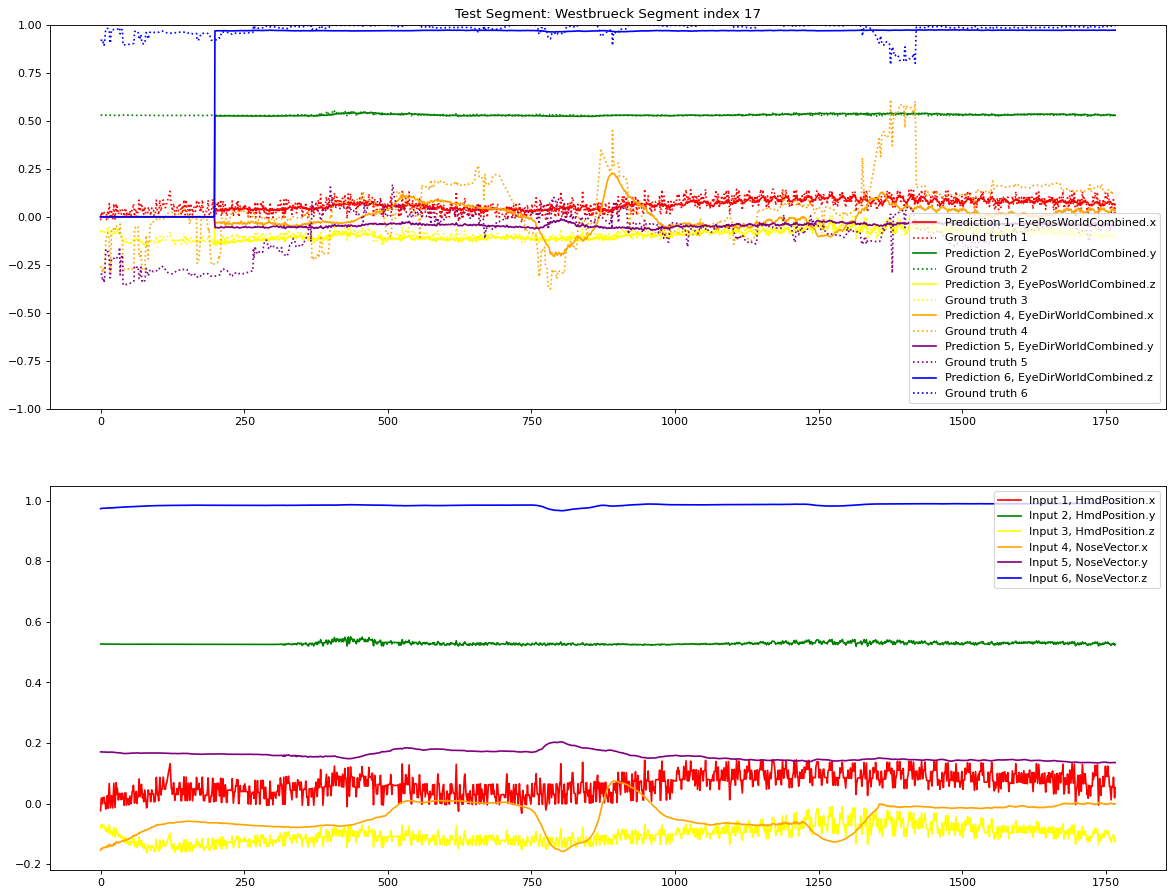

In [21]:
# Plot

fig, ax = plt.subplots(2, figsize=(18, 14), dpi=80)
colors_lut = ["red","green","yellow","orange","purple","blue"]

for dim in range(ret.shape[1]):
    ax[0].plot(ret[:,dim], color = colors_lut[dim], label = str("Prediction {}, {}".format(dim + 1, test_segment_data.columns[6+dim])))
    ax[0].plot(full_sequence_target[:,dim], linestyle = "dotted", markersize = 1, color = colors_lut[dim], label = str("Ground truth {}".format(dim + 1)))

ax[0].legend()
ax[0].set_ylim((-1,1))

for dim in range(full_sequence_in.shape[1]):
    ax[1].plot(full_sequence_in[:,dim], color = colors_lut[dim], label = str("Input {}, {}".format(dim + 1, test_segment_data.columns[dim])))

ax[1].legend()

ax[0].set_title("Test Segment: Westbrueck Segment index {}".format(test_segment_idx))

plt.show()


In [22]:
print("R2 score overall:")
print(r2_score(full_sequence_target[-sub_seq_len:,:],ret[-sub_seq_len:,:]))

print("\nR2 score per dim:")
for dim in [0,1,2,3,4,5]:
    print(r2_score(full_sequence_target[-sub_seq_len:,dim],ret[-sub_seq_len:,dim]))

print("\nMean squared error:")
print(mean_squared_error(full_sequence_target[-sub_seq_len:,:],ret[-sub_seq_len:,:]))

# root mean squared
print("\nRoot mean squared error:")
print(mean_squared_error(full_sequence_target[-sub_seq_len:,:],ret[-sub_seq_len:,:], squared = False))

print("\nRoot mean squared per dim")
for dim in [0,1,2,3,4,5]:
    print(mean_squared_error(full_sequence_target[-sub_seq_len:,dim],ret[-sub_seq_len:,dim], squared = False))

print("\nMean absolute error:")
print(mean_absolute_error(full_sequence_target[-sub_seq_len:,:],ret[-sub_seq_len:,:]))



R2 score overall:
-18.874268918791742

R2 score per dim:
0.23833062546026684
0.18951533517460062
0.08666181896837022
-84.89076351186462
-0.8330794309700331
-28.03627834951902

Mean squared error:
0.0032282157527883724

Root mean squared error:
0.03658230549812239

Root mean squared per dim
0.022502058834950673
0.0026784281655372276
0.014254158006285288
0.13166474852336346
0.03274063760612321
0.015653801852474537

Mean absolute error:
0.033772419243207334
